In [4]:
import numpy as np
import pandas as pd
import missingno as msno
import scipy.io as sio
import gsw
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({
    "figure.facecolor":  "white",  
    "savefig.facecolor": "white",  
    "figure.figsize": [8,6]
})
import scipy.signal as signal
import src.helper as helper
from src.location import Location
from src.ctd_cast import CTDCast
from src.mooring import Mooring
from geopy.distance import distance as geopy_distance
import datetime as datetime

In [6]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [5]:
# Get each mooring location

list_of_moorings = helper.IO.load_pickle(name="../../data/mooring/list_of_moorings.pkl")

mooring_locations = [mooring.location for mooring in list_of_moorings]
mooring_locations

[Location(lat=-63.4032, lon=-52.287),
 Location(lat=-63.5145, lon=-51.6357),
 Location(lat=-63.656, lon=-50.8113),
 Location(lat=-63.7783, lon=-50.0897),
 Location(lat=-63.917, lon=-49.2682),
 Location(lat=-64.0665, lon=-48.3805),
 Location(lat=-64.2157, lon=-47.4903)]

# Test out and explain the methode on the example of PS103

In [7]:
# Load and explore the PS103 Data
path = "/media/sf_VM_Folder/data/CTD/PS103_phys_oce.tab"
data = pd.read_csv(path, delimiter = "\t", skiprows=78)

#Drop all rows that are not even close to the mooring
data.drop(data[data.Latitude < -65].index, inplace = True)
data.drop(data[data.Latitude > -62].index, inplace = True)
data.drop(data[data.Longitude < -54].index, inplace = True)
data.drop(data[data.Longitude > -47].index, inplace = True)
data.reset_index(inplace = True)

#fix data types
data['Date/Time'] =  pd.to_datetime(data['Date/Time'])#, format='%d%b%Y:%H:%M:%S.%f')
data['Event'] = data['Event'].astype('category')

### Calculate SA, CT 

data["Absolute Salinity"] = gsw.SA_from_SP(
    SP=data["Sal"], p=data["Press [dbar]"], lon=data["Longitude"], lat=data["Latitude"]
)
data["Conservative Temperature"] = gsw.CT_from_t(
    SA=data["Absolute Salinity"], t=data["Temp [°C]"], p=data["Press [dbar]"]
)

In [8]:
#Look only at casts and their geographic location, the cast data itself will be used later
stats = data.groupby(['Event','Latitude','Longitude']).size().reset_index().rename(columns={0:'count'})
stats = stats.loc[(stats["count"]!=0)]
stats.drop(stats[stats["count"] < 200].index, inplace = True) #drop casts that contain not enough data (alternativly looking at the max depth of each cast would also be possible)
stats.reset_index(inplace = True)

### Calculate Distances to the mooring locations
from geopy.distance import distance as geopy_distance

for i,mooring_location in enumerate(mooring_locations):
    location_tuple = (mooring_location.lat, mooring_location.lon)
    stats[f"Dist. to {mooring_location}"] = stats.apply(lambda row : geopy_distance(location_tuple, (row.Latitude, row.Longitude)).km, axis = 1)

In [9]:
### Color the minimum distance in green 
def highlight_min(x):
    #c1 = 'background-color: green'
    c2 = 'background-color: #5eae76'
    # condition
    #m1 = x.eq(x.max())
    m2 = x.eq(x.min())
    # empty DataFrame of styles
    df1 = pd.DataFrame('', index=x.index, columns=x.columns)

    # set columns by conditions
    return df1.mask(m2, c2)
stats.style.apply(highlight_min, axis=None, subset= list(stats.columns)[5:])

,index,Event,Latitude,Longitude,count,"Dist. to (-63.40,-52.29)","Dist. to (-63.51,-51.64)","Dist. to (-63.66,-50.81)","Dist. to (-63.78,-50.09)","Dist. to (-63.92,-49.27)","Dist. to (-64.07,-48.38)","Dist. to (-64.22,-47.49)"
0,28,PS103_46-2,-64.210400,-47.396600,4249,257.120234,222.360913,178.497724,140.317686,97.045389,50.519552,4.588165
1,239,PS103_47-1,-64.254600,-47.000100,4350,276.942176,242.178393,198.311351,160.129266,116.859759,70.353517,24.176606
2,492,PS103_48-1,-64.067300,-48.372700,3948,206.989977,172.231892,128.371044,90.193805,46.923467,0.391060,46.033812
3,731,PS103_51-1,-63.892400,-49.080100,3513,167.966883,133.198871,89.363995,51.293368,9.633934,39.373190,85.595552
4,970,PS103_52-1,-63.845800,-49.621100,3215,141.088498,106.317507,62.448592,24.278679,19.071224,65.587679,112.008485
5,1209,PS103_53-1,-63.775200,-50.088300,2797,116.766190,81.996300,38.126860,0.352400,43.334900,89.870096,136.286420
6,1462,PS103_55-1,-63.587700,-51.306300,2194,53.002716,18.296398,25.701483,63.841754,107.091228,153.601746,199.991772
7,1673,PS103_56-1,-63.710800,-50.899100,2494,77.034723,42.591593,7.496193,40.668371,83.554304,129.917867,176.220681
8,1926,PS103_59-2,-63.483200,-51.596400,1927,35.597901,4.000556,43.502555,81.616725,124.875247,171.410248,217.829369
9,2179,PS103_60-1,-63.470900,-52.167400,855,9.622141,26.929754,70.476020,108.570340,151.773197,198.239966,244.589113


In [10]:
stats.sort_values(by=['Dist. to (-63.40,-52.29)']).style.apply(highlight_min, axis=None, subset= list(stats.columns)[5:])

,index,Event,Latitude,Longitude,count,"Dist. to (-63.40,-52.29)","Dist. to (-63.51,-51.64)","Dist. to (-63.66,-50.81)","Dist. to (-63.78,-50.09)","Dist. to (-63.92,-49.27)","Dist. to (-64.07,-48.38)","Dist. to (-64.22,-47.49)"
10,2418,PS103_61-1,-63.404100,-52.289400,650,0.156359,34.848315,78.714467,116.892691,160.155757,206.673017,253.065199
9,2179,PS103_60-1,-63.470900,-52.167400,855,9.622141,26.929754,70.476020,108.570340,151.773197,198.239966,244.589113
11,2657,PS103_62-1,-63.378100,-52.603400,476,16.063772,50.622619,94.422892,132.570380,175.804575,222.292887,268.657219
12,2840,PS103_65-1,-63.480300,-51.880900,1157,22.013549,12.794253,56.636893,94.811361,138.072099,184.588284,230.980696
8,1926,PS103_59-2,-63.483200,-51.596400,1927,35.597901,4.000556,43.502555,81.616725,124.875247,171.410248,217.829369
13,3121,PS103_66-1,-63.320400,-53.053300,434,39.443972,74.036178,117.797179,155.918179,199.126303,245.588346,291.927262
6,1462,PS103_55-1,-63.587700,-51.306300,2194,53.002716,18.296398,25.701483,63.841754,107.091228,153.601746,199.991772
14,3360,PS103_67-1,-63.222300,-53.702800,297,73.781087,108.425449,152.181340,190.288446,233.478195,279.918664,326.234718
7,1673,PS103_56-1,-63.710800,-50.899100,2494,77.034723,42.591593,7.496193,40.668371,83.554304,129.917867,176.220681
5,1209,PS103_53-1,-63.775200,-50.088300,2797,116.766190,81.996300,38.126860,0.352400,43.334900,89.870096,136.286420


In [11]:
# select only the closest CTD profiles
# Appending to a dataframe is bad form, but I still do it here because teh data frame remains very small

dict_of_closest_ctds = {str(mooring):[] for mooring in mooring_locations}

#pd.DataFrame(data = {"mooring": mooring_locations}, columns=['mooring', 'closest cast', '2nd closest cast', '3rd closest cast'])

#{mooring: for mooring in mooring_locations}


for mooring,column_name in zip(mooring_locations,(list(stats.columns)[5:])):
        # check current mooring against the column name to see if they refer to the same mooring
        assert str(mooring) == column_name[9:]
        
        # sort the dataframe after the distances to the current mooring
        # and add the first 3 cast names to the dictionary
        temp = stats.sort_values(by= column_name)
        dict_of_closest_ctds[str(mooring)].extend(temp["Event"].iloc[:3].to_list())

In [12]:
dict_of_closest_ctds

{'(-63.40,-52.29)': ['PS103_61-1', 'PS103_60-1', 'PS103_62-1'],
 '(-63.51,-51.64)': ['PS103_59-2', 'PS103_65-1', 'PS103_55-1'],
 '(-63.66,-50.81)': ['PS103_56-1', 'PS103_55-1', 'PS103_53-1'],
 '(-63.78,-50.09)': ['PS103_53-1', 'PS103_52-1', 'PS103_56-1'],
 '(-63.92,-49.27)': ['PS103_51-1', 'PS103_52-1', 'PS103_53-1'],
 '(-64.07,-48.38)': ['PS103_48-1', 'PS103_51-1', 'PS103_46-2'],
 '(-64.22,-47.49)': ['PS103_46-2', 'PS103_47-1', 'PS103_48-1']}

In [13]:
pd.DataFrame(data = dict_of_closest_ctds)

,"(-63.40,-52.29)","(-63.51,-51.64)","(-63.66,-50.81)","(-63.78,-50.09)","(-63.92,-49.27)","(-64.07,-48.38)","(-64.22,-47.49)"
0,PS103_61-1,PS103_59-2,PS103_56-1,PS103_53-1,PS103_51-1,PS103_48-1,PS103_46-2
1,PS103_60-1,PS103_65-1,PS103_55-1,PS103_52-1,PS103_52-1,PS103_51-1,PS103_47-1
2,PS103_62-1,PS103_55-1,PS103_53-1,PS103_56-1,PS103_53-1,PS103_46-2,PS103_48-1


In [14]:
grouped = data.groupby("Event")
events = grouped.groups.keys()
print(f"Number of Events/Casts = {len(events)}")

for mooring, closest_ctd_casts in dict_of_closest_ctds.items():
    print(mooring)
    for cast_name in closest_ctd_casts:
        #retrieve data 
        cast = grouped.get_group(cast_name)

Number of Events/Casts = 15
(-63.40,-52.29)
(-63.51,-51.64)
(-63.66,-50.81)
(-63.78,-50.09)
(-63.92,-49.27)
(-64.07,-48.38)
(-64.22,-47.49)


# Read and analyse all data

In [15]:
columns = ['Event', 'Date/Time', 'Latitude', 'Longitude',
       'Depth water [m]', 'Press [dbar]', 'Temp [°C]', 'Sal', "Absolute Salinity", "Conservative Temperature", 'Expedition']
CTDs = pd.DataFrame(columns=columns)

In [16]:
#definition of box around the transect 
m = (63.21 - 64.22)/(53.8 - 47)
b = 63.21 - m * 53.8
shift = 0.12

In [19]:
def get_PS129_CTD_data():    
    #get location of CTD files from the LADCP data files
    LADCP_DIRECTORY = f"/media/sf_VM_Folder/PS129_Plots/ladcp_profiles/"

    ladcp_paths = sorted(helper.IO.get_filepaths_from_directory(LADCP_DIRECTORY, inclusive = (".mat",)))

    #all CTD cast can be identified by a number
    ladcp_cast_numbers = [path.split('/')[-1][7:-4] for path in ladcp_paths]

    #create list of all CTD cast locations
    ctd_locations = []
    ctd_timestamps = []
    for path in ladcp_paths:
        data_struct = sio.loadmat(path) 
        data = data_struct["dr"][0][0]
        lat = np.round(np.squeeze(data["lat"]),3)
        lon = np.round(np.squeeze(data["lon"]),3)
        ctd_locations.append(Location(lat = lat, lon = lon))
        time_stamp = datetime.datetime(*map(int, np.squeeze(data["date"]))) #convert list of values to datetime object
        ctd_timestamps.append(time_stamp)
        
    # Set up conversion from ID number to cast name    
    def load_stations(path):
        transect_names, transect_numbers = np.loadtxt(path, dtype = (str), delimiter = "\t", unpack = True)
        translate = dict(zip(transect_names, transect_numbers))
        #print(translate)
        return translate
    name_to_number_dict = load_stations("/media/sf_VM_Folder/PS129_Plots/conversion.txt")
    number_to_name_dict = {int(v): k for k, v in name_to_number_dict.items()}    

    #create as many CTDCast objects as casts itself
    list_of_PS129_casts= [CTDCast() for _ in ladcp_cast_numbers]

    # for every cast object set a location and a name
    for i,cast in enumerate(list_of_PS129_casts):
        cast_number = ladcp_cast_numbers[i]
        cast_name = number_to_name_dict[int(cast_number)]
        cast.name = cast_name
        cast.location = ctd_locations[i]
        cast.date = ctd_timestamps[i]

    column_names = ['Event', "Latitude", "Longitude", "Press [dbar]", "Sal", "Temp [°C]", "Absolute Salinity", "Conservative Temperature", "Date/Time", "Depth water [m]", "Expedition"]
    data_dict = {name:[] for name in column_names}

    for cast in list_of_PS129_casts:
        #load actual data to that Cast name
        try:   
            path = f"/media/sf_VM_Folder/PS129_Plots/ctd_profiles/dps129_{cast.name}.cnv"
        
            #SP = Practical Salinity [PSU]
            #Temperature [ITS-90, °C]

            #add the cast data to the data dictionary
            pressure,in_situ_temperature,practical_salinity = np.genfromtxt(path, skip_header = 322, usecols = (0,1,5), unpack = True)
            data_dict["Event"].extend([f"PS129_{cast.name}"] * len(pressure))
            data_dict["Latitude"].extend([cast.location.lat] * len(pressure))
            data_dict["Longitude"].extend([cast.location.lon] * len(pressure))
            data_dict["Press [dbar]"].extend(pressure)
            data_dict["Temp [°C]"].extend(in_situ_temperature)
            data_dict["Sal"].extend(practical_salinity)
            data_dict["Date/Time"].extend([cast.date] * len(pressure))
            data_dict["Expedition"].extend(["PS129"] * len(pressure))
            
            #add new attributes
            SA = gsw.SA_from_SP(SP = practical_salinity, p = pressure, lon = cast.location.lon, lat = cast.location.lat)
            data_dict["Absolute Salinity"].extend(SA)
            data_dict["Conservative Temperature"].extend(gsw.CT_from_t(SA = SA, t = in_situ_temperature, p = pressure))
            data_dict["Depth water [m]"].extend(np.abs(gsw.z_from_p(p = pressure, lat = cast.location.lat)))
        
        except ValueError as e:
            print("Error at ",cast.name, cast.location)
            print(e)
            continue
        #print(cast.name)     
    #print(data_dict)
    for (k,v) in data_dict.items():
        print(k,len(v))
    return pd.DataFrame(data = data_dict)

In [20]:
PS129_CTDs = get_PS129_CTD_data()
CTDs = CTDs.merge(PS129_CTDs, on = columns, how = "outer")
#Drop all rows that are not even close to the moorings
CTDs.drop(CTDs[CTDs.Latitude < -64.5].index, inplace = True)
CTDs.drop(CTDs[CTDs.Latitude > -63].index, inplace = True)
CTDs.drop(CTDs[CTDs.Longitude < -54].index, inplace = True)
CTDs.drop(CTDs[CTDs.Longitude > -47].index, inplace = True)

CTDs.drop(CTDs[
    m*CTDs.Longitude-b+shift < CTDs.Latitude
].index, inplace = True)

CTDs.drop(CTDs[
    m*CTDs.Longitude-b-shift > CTDs.Latitude 
].index, inplace = True)

CTDs.reset_index(inplace = True, drop=True)
    
CTDs

Error at  018_07 (-59.09,0.12)
Some errors were detected !
    Line #323 (got 1 columns instead of 3)
Event 135941
Latitude 135941
Longitude 135941
Press [dbar] 135941
Sal 135941
Temp [°C] 135941
Absolute Salinity 135941
Conservative Temperature 135941
Date/Time 135941
Depth water [m] 135941
Expedition 135941


,Event,Latitude,Longitude,Press [dbar],Sal,Temp [°C],Absolute Salinity,Conservative Temperature,Date/Time,Depth water [m],Expedition
0,PS129_102_01,-64.131,-47.953,1.0,33.8873,-1.8490,34.052925,-1.844905,2022-04-20 06:44:16,0.990258,PS129
1,PS129_102_01,-64.131,-47.953,2.0,33.8840,-1.8451,34.049596,-1.841016,2022-04-20 06:44:16,1.980511,PS129
2,PS129_102_01,-64.131,-47.953,3.0,33.8830,-1.8433,34.048579,-1.839230,2022-04-20 06:44:16,2.970760,PS129
3,PS129_102_01,-64.131,-47.953,4.0,33.8836,-1.8438,34.049169,-1.839748,2022-04-20 06:44:16,3.961003,PS129
4,PS129_102_01,-64.131,-47.953,5.0,33.8853,-1.8467,34.050865,-1.842667,2022-04-20 06:44:16,4.951242,PS129
...,...,...,...,...,...,...,...,...,...,...,...
35926,PS129_122_01,-63.168,-53.955,227.0,34.4466,-0.9783,34.615488,-0.981688,2022-04-23 21:39:39,224.681402,PS129
35927,PS129_122_01,-63.168,-53.955,228.0,34.4465,-0.9782,34.615391,-0.981618,2022-04-23 21:39:39,225.670642,PS129
35928,PS129_122_01,-63.168,-53.955,229.0,34.4466,-0.9782,34.615494,-0.981648,2022-04-23 21:39:39,226.659877,PS129
35929,PS129_122_01,-63.168,-53.955,230.0,34.4466,-0.9782,34.615497,-0.981678,2022-04-23 21:39:39,227.649108,PS129


In [21]:
def find_line_number(filename, target_string):
    with open(filename, 'r') as file:
        for line_number, line in enumerate(file):
            if line.startswith(target_string):
                return line_number
    return None

In [22]:
data_paths = helper.IO.get_filepaths_from_directory(directory = "/media/sf_VM_Folder/data/CTD", inclusive = ".tab", exclusive = ())
for p in data_paths: print(p)

/media/sf_VM_Folder/data/CTD/ANT-IX_2_phys_oce.tab
/media/sf_VM_Folder/data/CTD/ANT-VIII_2_phys_oce.tab
/media/sf_VM_Folder/data/CTD/ANT-XIII_4_phys_oce.tab
/media/sf_VM_Folder/data/CTD/ANT-XIV_3_phys_oce.tab
/media/sf_VM_Folder/data/CTD/ANT-XV_4_phys_oce.tab
/media/sf_VM_Folder/data/CTD/ANT-XXII_3_phys_oce.tab
/media/sf_VM_Folder/data/CTD/ANT-XXIV_3_phys_oce.tab
/media/sf_VM_Folder/data/CTD/ANT-XXIX_2_phys_oce.tab
/media/sf_VM_Folder/data/CTD/ANT-XXIX_3_phys_oce.tab
/media/sf_VM_Folder/data/CTD/ANT-XXIX_6_phys_oce.tab
/media/sf_VM_Folder/data/CTD/ANT-XXVII_2_phys_oce.tab
/media/sf_VM_Folder/data/CTD/ANT-X_4_phys_oce.tab
/media/sf_VM_Folder/data/CTD/ANT-X_7_phys_oce.tab
/media/sf_VM_Folder/data/CTD/PS103_phys_oce.tab
/media/sf_VM_Folder/data/CTD/PS117_phys_oce.tab


PS18 /media/sf_VM_Folder/data/CTD/ANT-IX_2_phys_oce.tab
PS16 /media/sf_VM_Folder/data/CTD/ANT-VIII_2_phys_oce.tab
PS40 /media/sf_VM_Folder/data/CTD/ANT-XIII_4_phys_oce.tab
!! Error loading /media/sf_VM_Folder/data/CTD/ANT-XIV_3_phys_oce.tab
PS49 /media/sf_VM_Folder/data/CTD/ANT-XV_4_phys_oce.tab
PS67 /media/sf_VM_Folder/data/CTD/ANT-XXII_3_phys_oce.tab
PS71 /media/sf_VM_Folder/data/CTD/ANT-XXIV_3_phys_oce.tab
PS81 /media/sf_VM_Folder/data/CTD/ANT-XXIX_2_phys_oce.tab
!! Error loading /media/sf_VM_Folder/data/CTD/ANT-XXIX_3_phys_oce.tab
PS81 /media/sf_VM_Folder/data/CTD/ANT-XXIX_6_phys_oce.tab
PS77 /media/sf_VM_Folder/data/CTD/ANT-XXVII_2_phys_oce.tab
!! Error loading /media/sf_VM_Folder/data/CTD/ANT-X_4_phys_oce.tab
PS23 /media/sf_VM_Folder/data/CTD/ANT-X_7_phys_oce.tab
PS103 /media/sf_VM_Folder/data/CTD/PS103_phys_oce.tab
PS117 /media/sf_VM_Folder/data/CTD/PS117_phys_oce.tab


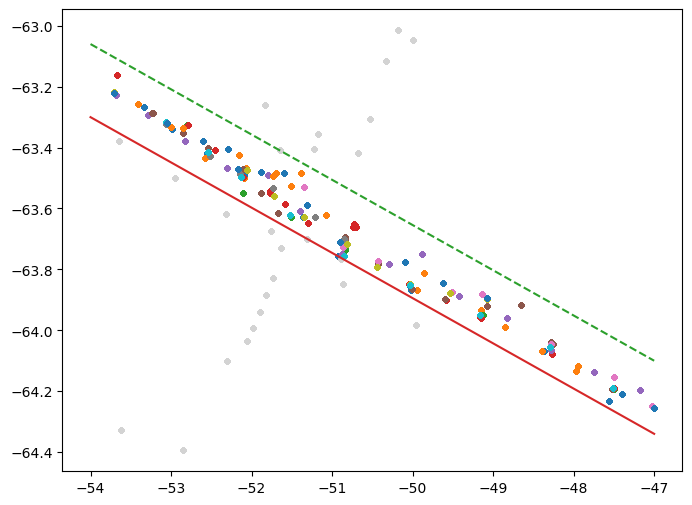

In [23]:
for i, path in enumerate(data_paths):
    target_string = "Event\tDate/Time\tLatitude\tLongitude\tElevation [m]"
    skiprows = find_line_number(path, target_string)
    if skiprows == None:
        target_string = "Event	Type	Date/Time	Longitude"
        skiprows = find_line_number(path, target_string)

    data = pd.read_csv(path, delimiter = "\t", skiprows= skiprows)
    
    data = data[data.columns.intersection(columns)]
    
    #Drop all rows that are not even close to the moorings
    data.drop(data[data.Latitude < -64.5].index, inplace = True)
    data.drop(data[data.Latitude > -63].index, inplace = True)
    data.drop(data[data.Longitude < -54].index, inplace = True)
    data.drop(data[data.Longitude > -47].index, inplace = True)
  
    # plot all CTDs as gret dots
    plt.plot(data.Longitude,data.Latitude, ".", color = "lightgrey")

    # remove every CTD profile outisde a bounding box
    data.drop(data[
        m*data.Longitude-b+shift < data.Latitude
    ].index, inplace = True)
    data.drop(data[
        m*data.Longitude-b-shift > data.Latitude 
    ].index, inplace = True)    
    data.reset_index(inplace = True, drop=True)
    
    data['Date/Time'] =  pd.to_datetime(data['Date/Time'])#, format='%d%b%Y:%H:%M:%S.%f')
    data['Event'] = data['Event'].astype('category')
    
    try:
        if data['Event'].iloc[0][4] != "/": 
            current_expedition = data['Event'].iloc[0][0:5]
        else:
            current_expedition = data['Event'].iloc[0][0:4]
        print(current_expedition, path)
        data['Expedition'] = current_expedition
        assert not data.empty
    
    except IndexError as e:
        print(f"!! Error loading {path}")
        assert data.empty
        continue            
   
    SA = gsw.SA_from_SP(SP = data["Sal"], p = data["Press [dbar]"], lon = data["Longitude"], lat = data["Latitude"])
    data["Absolute Salinity"] = SA
    
    CT = gsw.CT_from_t(SA = data["Absolute Salinity"], t = data["Temp [°C]"], p = data["Press [dbar]"])
    data["Conservative Temperature"] = CT
    
    plt.plot(data.Longitude,data.Latitude, ".", label = path.split("/")[-1])
    CTDs = CTDs.merge(data, on = columns, how = "outer")  
        
CTDs['Event'] = CTDs['Event'].astype('category')    
CTDs['Expedition'] = CTDs['Expedition'].astype('category')  
CTDs = CTDs.copy() #may prevent memory fragmentation created by merging data frames
x = np.linspace(-54,-47,4)
plt.plot(x,m*x-b+shift,"--")    
plt.plot(x,m*x-b-shift) 

#plt.legend()    

In [24]:
CTDs

,Event,Latitude,Longitude,Press [dbar],Sal,Temp [°C],Absolute Salinity,Conservative Temperature,Date/Time,Depth water [m],Expedition
0,PS129_102_01,-64.1310,-47.9530,1.0,33.8873,-1.8490,34.052925,-1.844905,2022-04-20 06:44:16,0.990258,PS129
1,PS129_102_01,-64.1310,-47.9530,2.0,33.8840,-1.8451,34.049596,-1.841016,2022-04-20 06:44:16,1.980511,PS129
2,PS129_102_01,-64.1310,-47.9530,3.0,33.8830,-1.8433,34.048579,-1.839230,2022-04-20 06:44:16,2.970760,PS129
3,PS129_102_01,-64.1310,-47.9530,4.0,33.8836,-1.8438,34.049169,-1.839748,2022-04-20 06:44:16,3.961003,PS129
4,PS129_102_01,-64.1310,-47.9530,5.0,33.8853,-1.8467,34.050865,-1.842667,2022-04-20 06:44:16,4.951242,PS129
...,...,...,...,...,...,...,...,...,...,...,...
281749,PS117_93-1,-63.2557,-53.4054,381.0,34.5890,-0.8440,34.759164,-0.853275,2019-01-31 22:21:00,377.000000,PS117
281750,PS117_93-1,-63.2557,-53.4054,382.0,34.5890,-0.8431,34.759167,-0.852413,2019-01-31 22:21:00,378.000000,PS117
281751,PS117_93-1,-63.2557,-53.4054,383.0,34.5891,-0.8413,34.759271,-0.850655,2019-01-31 22:21:00,378.900000,PS117
281752,PS117_93-1,-63.2557,-53.4054,384.0,34.5895,-0.8390,34.759677,-0.848400,2019-01-31 22:21:00,379.900000,PS117


In [25]:
CTDs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281754 entries, 0 to 281753
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Event                     281754 non-null  category      
 1   Latitude                  281754 non-null  float64       
 2   Longitude                 281754 non-null  float64       
 3   Press [dbar]              281754 non-null  float64       
 4   Sal                       281754 non-null  float64       
 5   Temp [°C]                 281595 non-null  float64       
 6   Absolute Salinity         281754 non-null  float64       
 7   Conservative Temperature  281595 non-null  float64       
 8   Date/Time                 281754 non-null  datetime64[ns]
 9   Depth water [m]           281754 non-null  float64       
 10  Expedition                281754 non-null  category      
dtypes: category(2), datetime64[ns](1), float64(8)
memory usage: 20.2 

In [26]:
# Get each mooring location
#list_of_moorings = helper.IO.load_pickle(name="/home/ole/Desktop/Mooring_Analysis/energy_levels/data/list_of_moorings")
mooring_locations = [mooring.location for mooring in list_of_moorings]
# create dictionary of the mooring coordinates with empty values
dict_of_closest_ctds = {str(mooring):[] for mooring in mooring_locations}

MAXIMUM_DISTANCE_FROM_MOORING = 20 #in kilometers
NUMBER_OF_CTDs_PER_MOORING = 26

#Look only at casts and their geographic location, the cast data itself will be used later
stats = CTDs.groupby(['Event','Latitude','Longitude']).size().reset_index().rename(columns={0:'count'})
stats = stats.loc[(stats["count"]!=0)]
#drop casts that contain not enough data (alternatively looking at the max depth of each cast would also be possible)
stats.drop(stats[stats["count"] < 200].index, inplace = True) 
stats.reset_index(inplace = True, drop=True)

#Calculate Distances to the mooring locations
for i,mooring_location in enumerate(mooring_locations):
    location_tuple = (mooring_location.lat, mooring_location.lon)
    stats[f"Dist. to {mooring_location}"] = stats.apply(lambda row : geopy_distance(location_tuple, (row.Latitude, row.Longitude)).km, axis = 1)

# select the 3 closest CTD profiles
# Appending to a dataframe is bad form, but I still do it here because teh data frame remains very small

# append names of closest cast to the respective mooring key
for mooring,column_mooring_name in zip(mooring_locations,(list(stats.columns)[4:])):
    # check current mooring against the column name to see if they refer to the same mooring
    #print(str(mooring),column_mooring_name[9:])
    assert str(mooring) == column_mooring_name[9:]

    # sort the dataframe after the distances to the current mooring
    # and get the first 3 closest casts 
    temp = stats.sort_values(by = column_mooring_name)

    list_of_events = temp["Event"].iloc[0:NUMBER_OF_CTDs_PER_MOORING].to_list()
    list_of_distances = temp[column_mooring_name].iloc[0:NUMBER_OF_CTDs_PER_MOORING].to_numpy()

    #replace all cast names with NaNs that are further away from the mooring location than allowed
    is_close = np.less_equal(list_of_distances,MAXIMUM_DISTANCE_FROM_MOORING)
    list_of_events = [event if close else np.nan for (event, close) in zip(list_of_events, is_close) ]

    #for sanity checks, take a look again at the new list_of_distances
    #list_of_distances = [np.round(distance,2) if close else np.nan for (distance, close) in zip(list_of_distances, is_close) ]


    print(mooring)
    print("   ",list_of_events,"\n   ",list_of_distances)

    dict_of_closest_ctds[str(mooring)].extend(list_of_events)

(-63.40,-52.29)
    ['PS103_61-1', 'PS129_119_01', 'PS117_82-1', 'PS67/124-1', 'PS49/005-1', 'PS103_60-1', 'PS81/512-1', 'PS81/513-1', 'PS71/220-2', 'PS129_117_01', 'PS71/221-1', 'PS23/070-2', 'PS77/120-1', 'PS71/221-2', 'PS16/148-1', 'PS23/069-4', 'PS18/041-1', 'PS49/007-3', 'PS18/042-1', 'PS77/111-3', 'PS16/147-1', 'PS16/146-1', 'PS103_62-1', 'PS40/101-1', nan, nan] 
    [ 0.15635909  1.06596929  6.93234935  7.22284917  8.32913869  9.62214074
 11.73997644 11.79570414 11.83122648 11.93444154 12.40380995 12.44207675
 12.50769083 12.76461396 13.07789017 13.18050561 13.49452844 13.74269024
 13.92607705 14.08379199 14.26395879 15.17470196 16.06377155 18.58729255
 22.0135487  22.81245072]
(-63.51,-51.64)
    ['PS103_59-2', 'PS129_114_02', 'PS16/149-1', 'PS117_85-1', 'PS81/514-1', 'PS117_75-1', 'PS77/112-1', 'PS49/006-1', 'PS49/008-1', 'PS49/010-1', 'PS67/123-1', 'PS129_112_01', 'PS129_116_01', 'PS71/218-1', 'PS103_65-1', 'PS23/068-4', 'PS16/150-1', 'PS71/219-1', 'PS40/100-1', 'PS81/109-1',

In [27]:
pd.DataFrame(data = dict_of_closest_ctds)

,"(-63.40,-52.29)","(-63.51,-51.64)","(-63.66,-50.81)","(-63.78,-50.09)","(-63.92,-49.27)","(-64.07,-48.38)","(-64.22,-47.49)"
0,PS103_61-1,PS103_59-2,PS129_109_03,PS103_53-1,PS16/153-1,PS103_48-1,PS40/096-1
1,PS129_119_01,PS129_114_02,PS49/011-3,PS40/098-1,PS23/063-3,PS129_103_01,PS77/103-1
2,PS117_82-1,PS16/149-1,PS49/011-2,PS49/013-1,PS18/046-1,PS23/062-4,PS49/017-1
3,PS67/124-1,PS117_85-1,PS49/011-5,PS81/106-1,PS49/015-2,PS77/104-1,PS71/209-1
4,PS49/005-1,PS81/514-1,PS71/216-5,PS77/107-1,PS129_105_01,PS67/116-1,PS23/061-1
5,PS103_60-1,PS117_75-1,PS49/011-6,PS23/064-1,PS49/015-1,PS49/016-1,PS18/047-1
6,PS81/512-1,PS77/112-1,PS71/216-4,PS67/120-1,PS40/097-1,PS81/103-1,PS103_46-2
7,PS81/513-1,PS49/006-1,PS49/011-4,PS71/214-1,PS81/104-3,PS71/210-3,PS81/102-1
8,PS71/220-2,PS49/008-1,PS81/516-1,PS18/045-1,PS67/118-1,PS71/210-2,PS67/114-1
9,PS129_117_01,PS49/010-1,PS71/216-1,PS67/119-1,PS71/212-1,NaN,PS67/115-1


In [28]:
def smooth(array,length):
    window = signal.windows.hann(length)  # construct Hanning window
    smoothed = signal.convolve(array, window, mode="same") / np.sum(window)  # smooth by convolving speed with window
    return smoothed

In [29]:
def draw_mooring_depths(axis):
    
    moorings = [
        [299,505,614],      #mooring 1
        [1318,1513,1625],   #mooring 2
        [750,2143,2350],    #mooring 3
        [2400,2615,2724],   #mooring 4
        [3036,3299,3358],   #mooring 5
        [3835],             #mooring 6
        [4120,4160],        #mooring 7
    ]
    
    for ax, depths in zip(axis, moorings):
        for depth in depths:
            ax.axhline(depth, c = "k", alpha = 0.6) 

# Buoyancy Frequency

## First we look at $N^2$

In [30]:
def plot_averaged_N2(smoothing_window_size):

    f,axis = plt.subplots(ncols = len(mooring_locations), sharey = True, sharex = True, figsize = (14,6))

    comparison_z_axis = np.arange(0,1000,2)

    CTDs_grouped = CTDs.groupby("Event")

    for ax, (mooring, closest_ctd_casts) in zip(axis,dict_of_closest_ctds.items()):
        ax.set_title(mooring)
        ax.axvline(0, color = "k", ls = "--", zorder = 5)
        #print(closest_ctd_casts, pd.isna(closest_ctd_casts))
        number_of_valid_profiles = (~pd.isna(closest_ctd_casts)).sum()
        ax.text(0.9,0.95, s= f"{number_of_valid_profiles} casts", ha = "right", transform=ax.transAxes, bbox=dict(facecolor='white', alpha = 0.6, edgecolor='black', boxstyle='round'))

        # for calculating mean N2 profile for each mooring
        N2_array = []
        for cast_name in closest_ctd_casts:
            if pd.isna(cast_name): continue       

            #retrieve data 
            cast = CTDs_grouped.get_group(cast_name)

            #calculate square of buoyancy frequency    
            N2, N2pressure = gsw.Nsquared(
                SA = cast["Absolute Salinity"],
                CT = cast["Conservative Temperature"],
                p = cast["Press [dbar]"],
                lat = cast["Latitude"])
            depth = -1*gsw.z_from_p(p = N2pressure, lat = cast["Latitude"].mean()) 

            #convert N2 from (rad/s)^2 to 1/s^2
            #N2 = N2_in_radians / (2*np.pi)**2
            if smoothing_window_size != 0:
                N2 = smooth(N2,smoothing_window_size)

            # change vertical coordinate 
            # to "meters above ground" or "distance from seafloor"
            mab = max(depth) - depth
            ax.plot(N2,mab, c = "lightgrey")

            # interpolate to common grid
            new_N2 = np.interp(
                x = comparison_z_axis,
                xp = mab[::-1], #mab and N2 are reversed so that mab monotonically increases
                fp = N2[::-1]
                )
            N2_array.append(new_N2)

        mean_N2 = np.nanmean(N2_array, axis = 0)  #calculating the average
        median_N2 = np.nanmedian(N2_array, axis = 0)  #calculating the average
        #std_N2 = np.std(N2_array, axis = 0)


        ax.plot(median_N2, comparison_z_axis, "k", lw = 2) #plot median N2
        ax.plot(mean_N2, comparison_z_axis, "--", lw = 2, alpha = 0.7) #plot mean N2
        ax.set_xlabel("$N^2$ (rad$^2$/s$^2$)")
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        
    axis[0].set_ylabel("Meters above ground")
    axis[0].set_ylim(-20,1400)
    axis[0].set_xlim(-1.5e-6,9.5e-6)
    #axis[0].set_xlim(-1.5e-6,5e-4)
    f.tight_layout()

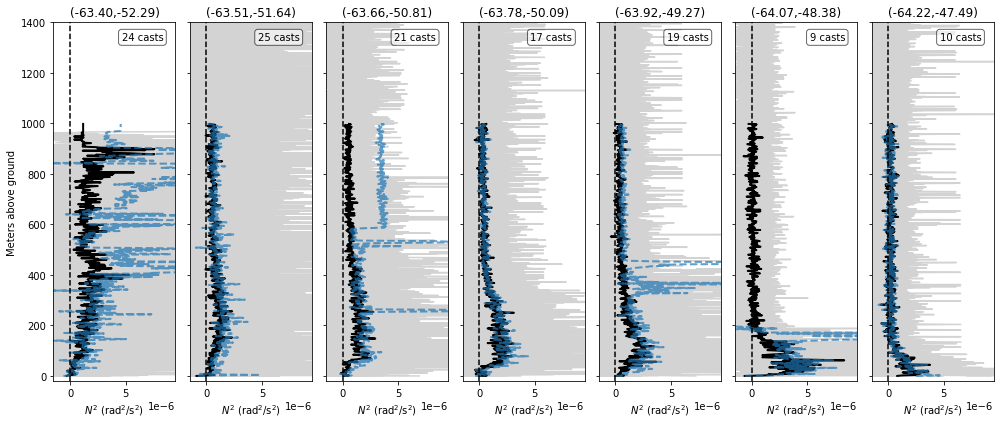

In [26]:
plot_averaged_N2(smoothing_window_size = 0)

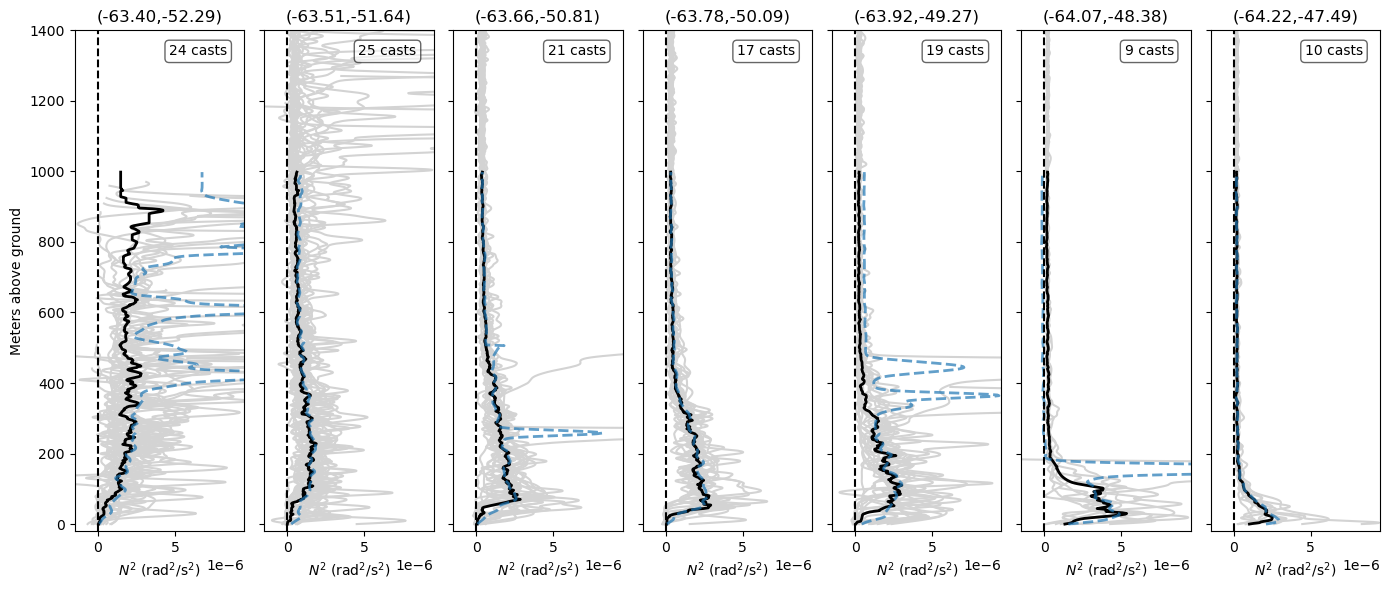

In [31]:
plot_averaged_N2(smoothing_window_size = 32)

## Then at $N$

First $N^2$ is calculated, than averaged over the profiles and then the square root to get $N$ is taken.

In [32]:
def plot_averaged_N(smoothing_window_size):
    f,axis = plt.subplots(ncols = len(mooring_locations), sharey = True, sharex = True, figsize = (14,6))

    comparison_z_axis = np.arange(0,1000,2)

    CTDs_grouped = CTDs.groupby("Event")
    result_dict = {"mab":comparison_z_axis}
    
    for ax, (mooring, closest_ctd_casts) in zip(axis,dict_of_closest_ctds.items()):
        ax.set_title(mooring)
        ax.axvline(0, color = "k", ls = "--", zorder = 5)
        #print(closest_ctd_casts, pd.isna(closest_ctd_casts))
        number_of_valid_profiles = (~pd.isna(closest_ctd_casts)).sum()
        ax.text(0.9,0.95, s= f"{number_of_valid_profiles} casts", ha = "right", transform=ax.transAxes, bbox=dict(facecolor='white', alpha = 0.6, edgecolor='black', boxstyle='round'))

        # for calculating mean N2 profile for each mooring
        N2_array = []
        for cast_name in closest_ctd_casts:
            if pd.isna(cast_name): continue       

            #retrieve data 
            cast = CTDs_grouped.get_group(cast_name)

            #calculate square of buoyancy frequency    
            N2, N2pressure = gsw.Nsquared(
                SA = cast["Absolute Salinity"],
                CT = cast["Conservative Temperature"],
                p = cast["Press [dbar]"],
                lat = cast["Latitude"])
            depth = -1*gsw.z_from_p(p = N2pressure, lat = cast["Latitude"].mean()) 

            #convert N2 from (rad/s)^2 to 1/s^2
            #N2 = N2_in_radians / (2*np.pi)**2
            N2 = smooth(N2,smoothing_window_size)

            # change vertical coordinate 
            # to "meters above ground" or "distance from seafloor"
            mab = max(depth) - depth
            ax.plot(np.sqrt(N2),mab, c = "lightgrey")

            # interpolate to common grid
            new_N2 = np.interp(
                x = comparison_z_axis,
                xp = mab[::-1], #mab and N2 are reversed so that mab monotonically increases
                fp = N2[::-1]
                )
            N2_array.append(new_N2)

        mean_N2 = np.nanmean(N2_array, axis = 0)  #calculating the average
        median_N2 = np.nanmedian(N2_array, axis = 0)  #calculating the average
        #std_N2 = np.std(N2_array, axis = 0)
        ax.plot(np.sqrt(median_N2), comparison_z_axis, "k", lw = 2) #plot median N2
        ax.plot(np.sqrt(mean_N2), comparison_z_axis, "--", lw = 2, alpha = 0.7) #plot mean N2

        result_dict[mooring] = np.sqrt(mean_N2)

        ax.set_xlabel("$N$ / (rad/s)")
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        
    axis[0].set_ylabel("Meters above ground")
    ax.set_ylim(-20,950)
    ax.set_xlim(-3e-4,4e-3)
    f.tight_layout()

In [29]:
#pd.DataFrame(result_dict).to_pickle("./poster_N_values.pkl")  
#pd.DataFrame(result_dict)

/tmp/ipykernel_2290/1615506903.py:39: RuntimeWarning: invalid value encountered in sqrt
  ax.plot(np.sqrt(N2),mab, c = "lightgrey")
/tmp/ipykernel_2290/1615506903.py:53: RuntimeWarning: invalid value encountered in sqrt
  ax.plot(np.sqrt(mean_N2), comparison_z_axis, "--", lw = 2, alpha = 0.7) #plot mean N2
/tmp/ipykernel_2290/1615506903.py:55: RuntimeWarning: invalid value encountered in sqrt
  result_dict[mooring] = np.sqrt(mean_N2)


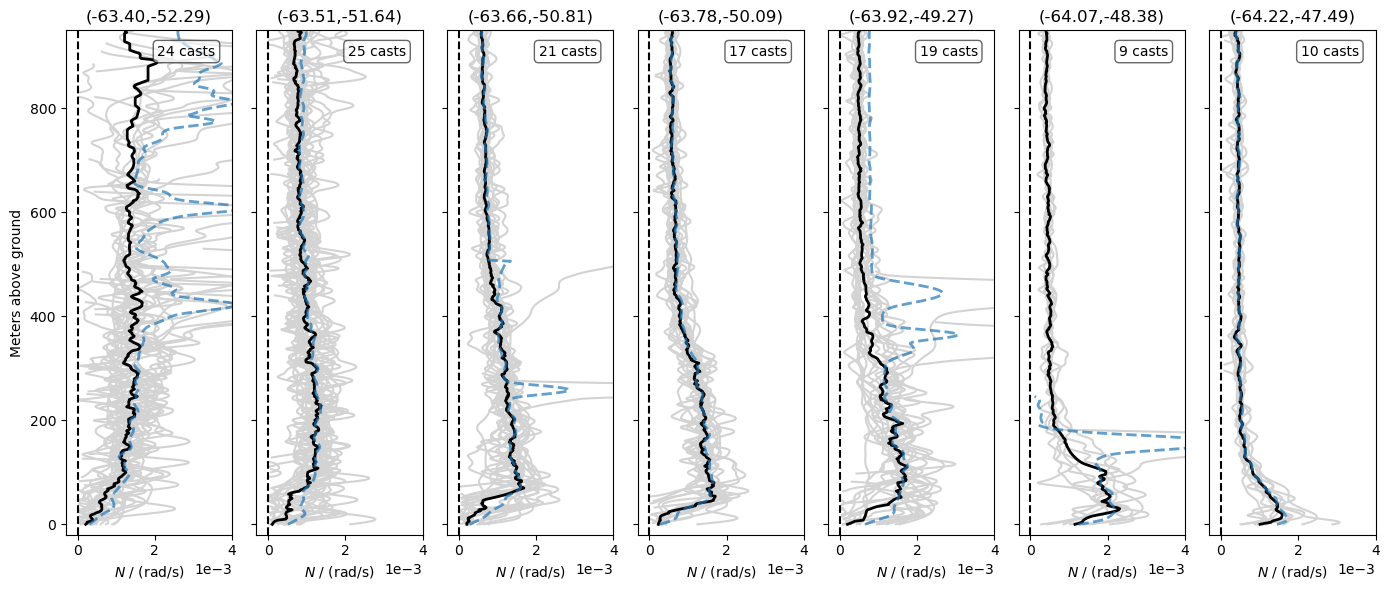

In [33]:
plot_averaged_N(smoothing_window_size = 32)

/tmp/ipykernel_2290/1615506903.py:39: RuntimeWarning: invalid value encountered in sqrt
  ax.plot(np.sqrt(N2),mab, c = "lightgrey")


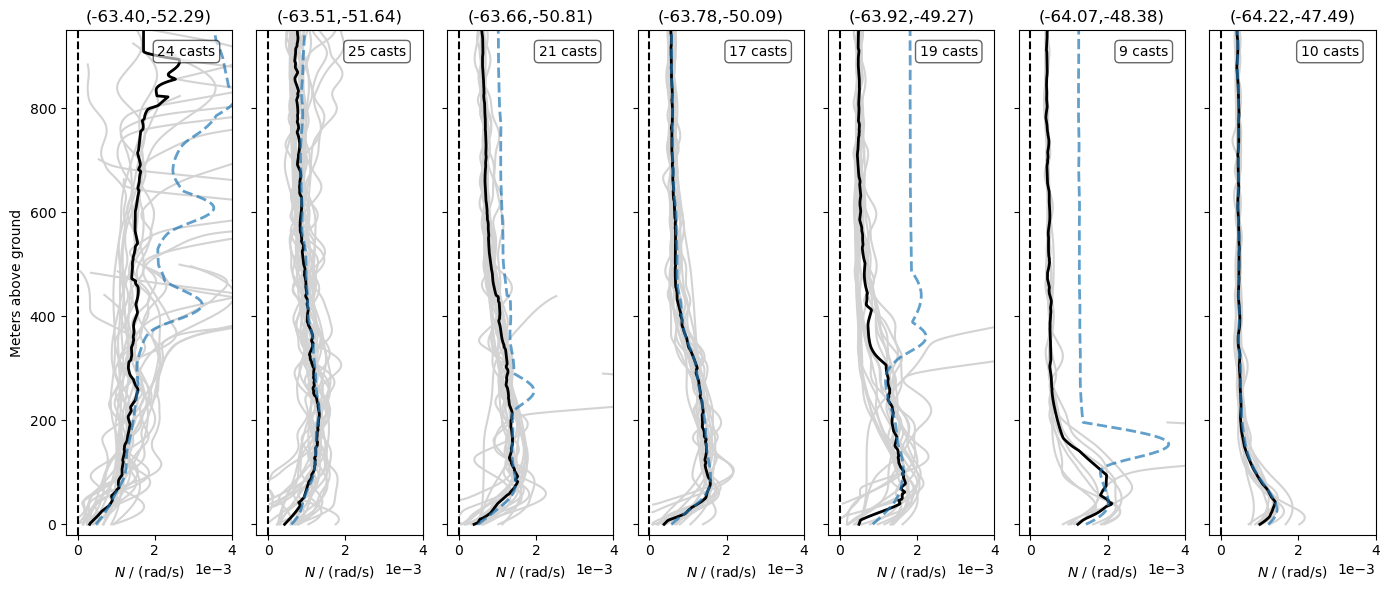

In [34]:
plot_averaged_N(smoothing_window_size = 100)

# Calculate Uncertainty of N  

From $N = \sqrt{N^2} = (N^2)^\frac{1}{2}$, we can derive that  
$
    \Delta N = \frac{1}{2} (N^2)^{-1/2}  \Delta N^2
$

In [36]:
def calculate_N_with_uncertainties(smoothing_window_size):
    f,axis = plt.subplots(ncols = len(mooring_locations), sharey = True, sharex = True, figsize = (14,6))

    comparison_z_axis = np.arange(0,600,1)

    CTDs_grouped = CTDs.groupby("Event")
    result_dict = {"mab":comparison_z_axis}
    error_dict = {"mab":comparison_z_axis}
    
    for ax, (mooring, closest_ctd_casts) in zip(axis,dict_of_closest_ctds.items()):
        ax.set_title(mooring)
        ax.axvline(0, color = "k", ls = "--", zorder = 5)
        #print(closest_ctd_casts, pd.isna(closest_ctd_casts))
        number_of_valid_profiles = (~pd.isna(closest_ctd_casts)).sum()
        ax.text(0.9,0.95, s= f"{number_of_valid_profiles} casts", ha = "right", transform=ax.transAxes, bbox=dict(facecolor='white', alpha = 0.6, edgecolor='black', boxstyle='round'))

        # for calculating mean N2 profile for each mooring
        N2_array = []
        for cast_name in closest_ctd_casts:
            if pd.isna(cast_name): continue       

            #retrieve data 
            cast = CTDs_grouped.get_group(cast_name)

            #calculate square of buoyancy frequency    
            N2, N2pressure = gsw.Nsquared(
                SA = cast["Absolute Salinity"],
                CT = cast["Conservative Temperature"],
                p = cast["Press [dbar]"],
                lat = cast["Latitude"])
            depth = -1*gsw.z_from_p(p = N2pressure, lat = cast["Latitude"].mean()) 

            #convert N2 from (rad/s)^2 to 1/s^2
            #N2 = N2_in_radians / (2*np.pi)**2
            N2 = smooth(N2,smoothing_window_size)

            # change vertical coordinate 
            # to "meters above ground" or "distance from seafloor"
            mab = max(depth) - depth
            ax.plot(np.sqrt(N2),mab, c = "lightgrey", zorder = -1)

            # interpolate to common grid
            new_N2 = np.interp(
                x = comparison_z_axis,
                xp = mab[::-1], #mab and N2 are reversed so that mab monotonically increases
                fp = N2[::-1]
                )
            N2_array.append(new_N2)

        mean_N2 = np.nanmean(N2_array, axis = 0)  #calculating the average
        median_N2 = np.nanmedian(N2_array, axis = 0)  #calculating the average
        std_N2 = np.nanstd(N2_array, axis = 0)
        d = np.abs(N2_array - np.nanmedian(N2_array, axis = 0))
        median_absolute_distance = np.nanmedian(d, axis = 0)
        
        ax.plot(np.sqrt(median_N2), comparison_z_axis, "k", lw = 2, zorder = 10) #plot median N2
        ax.plot(np.sqrt(mean_N2), comparison_z_axis, "g--", lw = 2, alpha = 0.7) #plot mean N2

        #error of N from gaussian error propagation
        delta_N_std = 1/2 * (mean_N2)**(-1/2) * std_N2
        delta_N_mad = 1/2 * (median_N2)**(-1/2) * median_absolute_distance
        
        #ax.fill_betweenx(y = comparison_z_axis, x1 = np.sqrt(mean_N2) - delta_N_std, x2 = np.sqrt(mean_N2) + delta_N_std, alpha = 0.5) #plot mean N2
        ax.fill_betweenx(y = comparison_z_axis, x1 = np.sqrt(median_N2) - delta_N_mad, x2 = np.sqrt(median_N2) + delta_N_mad, alpha = 1) #plot mean N2
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    
        result_dict[mooring] = np.sqrt(median_N2)

        error_dict[mooring] = delta_N_mad

        ax.set_xlabel("$N$ / (rad/s)")

    axis[0].set_ylabel("Meters above ground")
    ax.set_ylim(-20,550)
    ax.set_xlim(-3e-4,3e-3)
    f.tight_layout()
    
    return result_dict, error_dict

/tmp/ipykernel_2290/1436997493.py:40: RuntimeWarning: invalid value encountered in sqrt
  ax.plot(np.sqrt(N2),mab, c = "lightgrey", zorder = -1)
/tmp/ipykernel_2290/1436997493.py:56: RuntimeWarning: invalid value encountered in sqrt
  ax.plot(np.sqrt(median_N2), comparison_z_axis, "k", lw = 2, zorder = 10) #plot median N2
/tmp/ipykernel_2290/1436997493.py:57: RuntimeWarning: invalid value encountered in sqrt
  ax.plot(np.sqrt(mean_N2), comparison_z_axis, "g--", lw = 2, alpha = 0.7) #plot mean N2
/tmp/ipykernel_2290/1436997493.py:60: RuntimeWarning: invalid value encountered in power
  delta_N_std = 1/2 * (mean_N2)**(-1/2) * std_N2
/tmp/ipykernel_2290/1436997493.py:61: RuntimeWarning: invalid value encountered in power
  delta_N_mad = 1/2 * (median_N2)**(-1/2) * median_absolute_distance
/tmp/ipykernel_2290/1436997493.py:64: RuntimeWarning: invalid value encountered in sqrt
  ax.fill_betweenx(y = comparison_z_axis, x1 = np.sqrt(median_N2) - delta_N_mad, x2 = np.sqrt(median_N2) + delta_N_

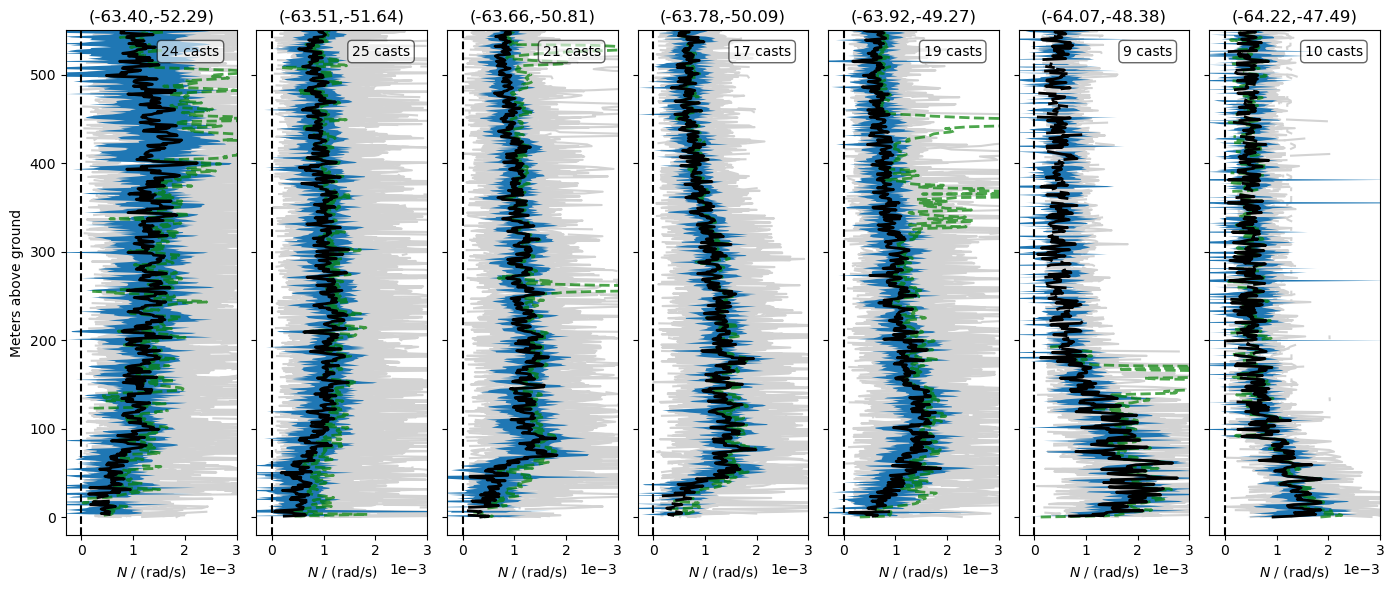

In [37]:
result_dict, error_dict = calculate_N_with_uncertainties(smoothing_window_size = 4)

/tmp/ipykernel_2290/1436997493.py:40: RuntimeWarning: invalid value encountered in sqrt
  ax.plot(np.sqrt(N2),mab, c = "lightgrey", zorder = -1)
/tmp/ipykernel_2290/1436997493.py:56: RuntimeWarning: invalid value encountered in sqrt
  ax.plot(np.sqrt(median_N2), comparison_z_axis, "k", lw = 2, zorder = 10) #plot median N2
/tmp/ipykernel_2290/1436997493.py:61: RuntimeWarning: invalid value encountered in power
  delta_N_mad = 1/2 * (median_N2)**(-1/2) * median_absolute_distance
/tmp/ipykernel_2290/1436997493.py:64: RuntimeWarning: invalid value encountered in sqrt
  ax.fill_betweenx(y = comparison_z_axis, x1 = np.sqrt(median_N2) - delta_N_mad, x2 = np.sqrt(median_N2) + delta_N_mad, alpha = 1) #plot mean N2
/tmp/ipykernel_2290/1436997493.py:67: RuntimeWarning: invalid value encountered in sqrt
  result_dict[mooring] = np.sqrt(median_N2)
/tmp/ipykernel_2290/1436997493.py:57: RuntimeWarning: invalid value encountered in sqrt
  ax.plot(np.sqrt(mean_N2), comparison_z_axis, "g--", lw = 2, alp

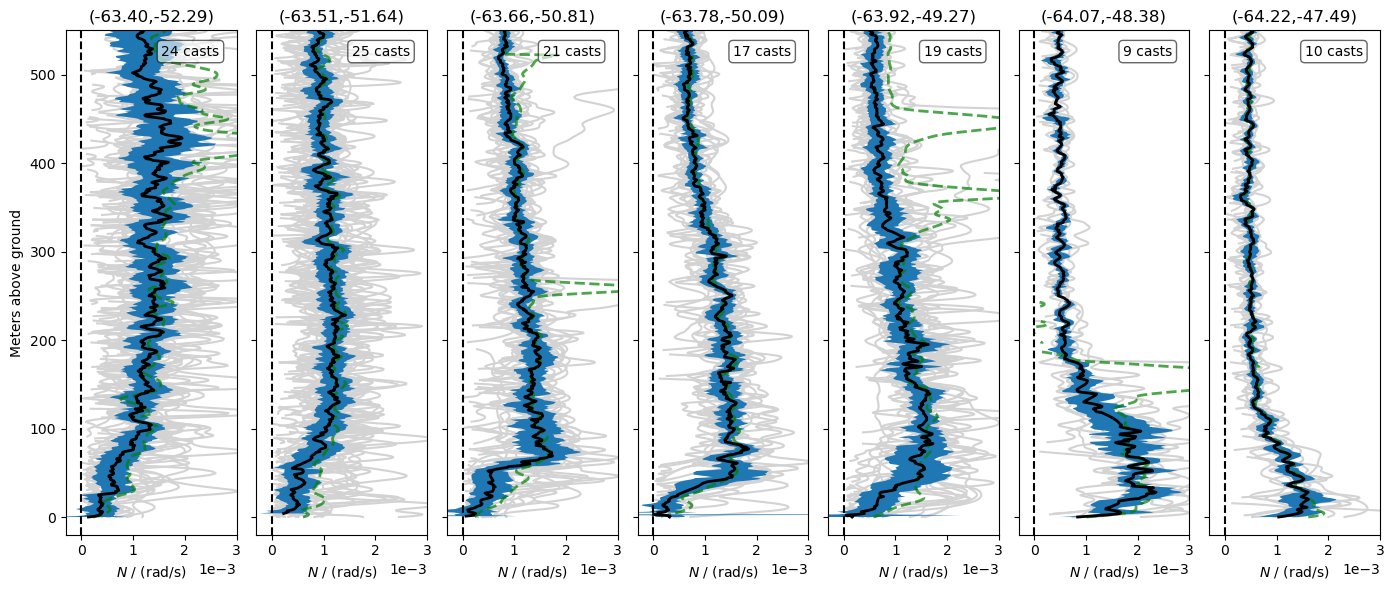

In [38]:
result_dict, error_dict = calculate_N_with_uncertainties(smoothing_window_size = 16)

/tmp/ipykernel_2290/1436997493.py:40: RuntimeWarning: invalid value encountered in sqrt
  ax.plot(np.sqrt(N2),mab, c = "lightgrey", zorder = -1)
/tmp/ipykernel_2290/1436997493.py:57: RuntimeWarning: invalid value encountered in sqrt
  ax.plot(np.sqrt(mean_N2), comparison_z_axis, "g--", lw = 2, alpha = 0.7) #plot mean N2
/tmp/ipykernel_2290/1436997493.py:60: RuntimeWarning: invalid value encountered in power
  delta_N_std = 1/2 * (mean_N2)**(-1/2) * std_N2


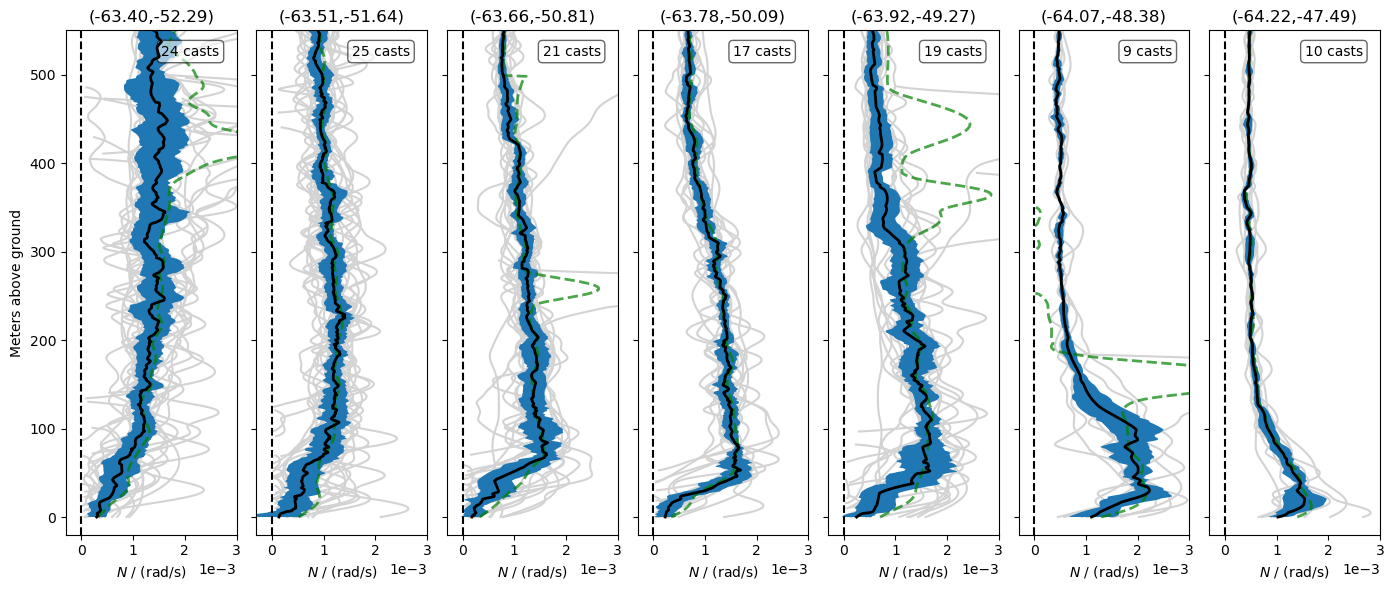

In [53]:
result_dict, error_dict = calculate_N_with_uncertainties(smoothing_window_size = 40)

In [54]:
pd.DataFrame(result_dict).to_pickle("./method_data/N_values.pkl")  
pd.DataFrame(result_dict)

,mab,"(-63.40,-52.29)","(-63.51,-51.64)","(-63.66,-50.81)","(-63.78,-50.09)","(-63.92,-49.27)","(-64.07,-48.38)","(-64.22,-47.49)"
0,0,0.000295,0.000136,0.000180,0.000234,0.000250,0.001107,0.001026
1,1,0.000314,0.000142,0.000181,0.000238,0.000271,0.001147,0.001098
2,2,0.000315,0.000145,0.000225,0.000242,0.000301,0.001182,0.001154
3,3,0.000307,0.000159,0.000223,0.000246,0.000325,0.001212,0.001183
4,4,0.000303,0.000171,0.000249,0.000250,0.000368,0.001237,0.001206
...,...,...,...,...,...,...,...,...
595,595,0.001432,0.000846,0.000719,0.000679,0.000540,0.000486,0.000455
596,596,0.001431,0.000852,0.000721,0.000677,0.000541,0.000483,0.000457
597,597,0.001427,0.000858,0.000716,0.000675,0.000541,0.000498,0.000458
598,598,0.001422,0.000857,0.000711,0.000674,0.000539,0.000497,0.000458


In [56]:
pd.DataFrame(error_dict).to_pickle("./method_data/N_std.pkl")  
pd.DataFrame(error_dict)

,mab,"(-63.40,-52.29)","(-63.51,-51.64)","(-63.66,-50.81)","(-63.78,-50.09)","(-63.92,-49.27)","(-64.07,-48.38)","(-64.22,-47.49)"
0,0,0.000176,0.000434,0.000199,0.000222,0.000294,0.000431,0.000192
1,1,0.000173,0.000419,0.000195,0.000194,0.000280,0.000451,0.000207
2,2,0.000177,0.000463,0.000188,0.000159,0.000307,0.000441,0.000207
3,3,0.000186,0.000520,0.000209,0.000213,0.000286,0.000425,0.000185
4,4,0.000197,0.000397,0.000217,0.000187,0.000275,0.000404,0.000204
...,...,...,...,...,...,...,...,...
595,595,0.000365,0.000152,0.000053,0.000123,0.000092,0.000049,0.000027
596,596,0.000354,0.000162,0.000050,0.000131,0.000091,0.000054,0.000029
597,597,0.000340,0.000140,0.000048,0.000137,0.000092,0.000049,0.000033
598,598,0.000334,0.000125,0.000058,0.000133,0.000093,0.000049,0.000040
